### Importar bibliotecas

In [4]:
import pandas as pd
import numpy as np
from src.Particle import ParticleType
from src.JetBuilder import JetBuilder
from src.JetImage import JetImage, JetImageCalculator, JetImageCalculatorPandas, JetImageAvarageCalculator
from src.Preprocessing import PreprocessingJetImages
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPool2D #Dense = MPLNN
from keras.optimizers import RMSprop,Adam

### Leitura de dados

In [2]:
data_gluon = pd.read_csv('../Dados/g_jets.csv', header=None, sep=' ')
data_quark = pd.read_csv('../Dados/q_jets.csv', header=None, sep=' ')
data_top = pd.read_csv('../Dados/t_jets.csv', header=None, sep=' ')

### Construção de jatos

- Tempo para carregar todos os dados: 38m 3.6s
- Tempo para carregar 500 jatos: 13.9s

In [3]:
# creating the list with the jets objects
jet_builder = JetBuilder()
# For the data exploration this amount of jets is enough
# More than that the evaluation stars to become really slower
gluon_jets = jet_builder.create_jets(data_frame=data_gluon[:500], jet_type=ParticleType.Gluon)
quark_jets = jet_builder.create_jets(data_frame=data_quark[:500], jet_type=ParticleType.LightQuark)
top_jets = jet_builder.create_jets(data_frame=data_top[:500], jet_type=ParticleType.Top)

#### Geração de imagens

In [32]:
jet_image = JetImage((-0.3, 0.3), (-0.3, 0.3), 25, 25, JetImageCalculator())

In [33]:
first_gluon_image = jet_image.create_jet_image(gluon_jets[10])

In [6]:
# Create a custom colormap that transitions from white to blue to red
colors = [(1, 1, 1), (0, 0, 1), (1, 0, 0)]  # White, Blue, Red
n_bins = 100  # Number of bins for interpolation
custom_cmap = LinearSegmentedColormap.from_list('white_blue_red', colors, N=n_bins)

Text(0, 0.5, '$\\eta^{rel}$')

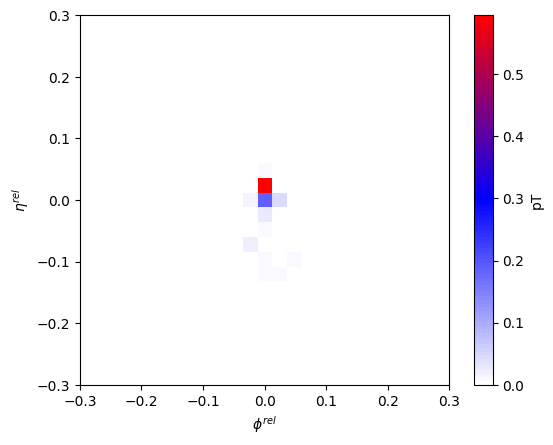

In [34]:
# import numpy as np
plt.imshow(first_gluon_image, cmap=custom_cmap, extent=(-0.3, 0.3, -0.3, 0.3))
plt.colorbar(label='pT')
plt.xlabel(r'$\phi^{rel}$')
plt.ylabel(r'$\eta^{rel}$')

In [42]:
single_jet_image = JetImageCalculator()
avg_jet_image = JetImageAvarageCalculator(jet_image_calculator=single_jet_image)
jet_image_avg = JetImage((-0.25, 0.25), (-0.25, 0.25), 20, 20, avg_jet_image)

Text(0, 0.5, '$\\eta^{rel}$')

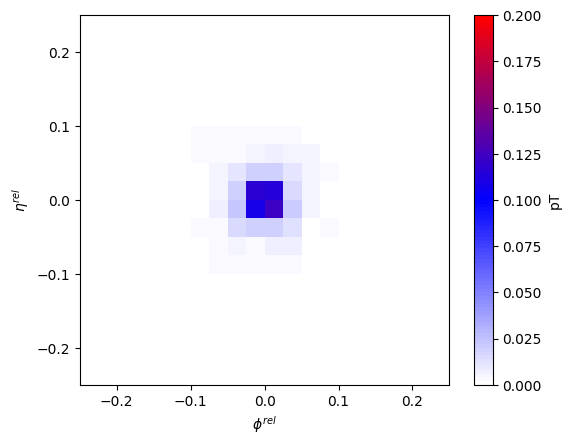

In [48]:
# evaluating the image using Jet class
avg_jet_image = jet_image_avg.create_jet_image(gluon_jets)
# plotting the grid
plt.imshow(avg_jet_image, cmap=custom_cmap, extent=(-0.25, 0.25, -0.25, 0.25), vmin=0, vmax=0.2)
plt.colorbar(label='pT')
plt.xlabel(r'$\phi^{rel}$')
plt.ylabel(r'$\eta^{rel}$')

### Organização dos dados como o MNIST

In [9]:
#Cria um array pra cada jato e associa a ele se ele é um g, t ou q
t_tam = len(top_jets)
q_tam = len(quark_jets)
g_tam = len(gluon_jets)
tam_particulas = t_tam + q_tam + g_tam

dados_particulas = np.empty((tam_particulas,81))
label = np.zeros((t_tam+q_tam+g_tam,3))

for i in range(t_tam):

    top_image = jet_image.create_jet_image(top_jets[i])
    top_image = top_image.reshape(1,81)

    label[i,0] = 1.0
    dados_particulas[i] = top_image

for i in range(q_tam):

    quark_image = jet_image.create_jet_image(quark_jets[i])
    quark_image = quark_image.reshape(1,81)

    label[i+t_tam,1] = 1.0
    dados_particulas[i+t_tam] = quark_image

for i in range(g_tam):

    gluon_image = jet_image.create_jet_image(gluon_jets[i])
    gluon_image = gluon_image.reshape(1,81)

    label[i+t_tam+q_tam,2] = 1.0
    dados_particulas[i+t_tam+q_tam] = gluon_image

dados = (dados_particulas,label)
dados

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]))

### Particionamento dos dados

In [10]:
X, Y = dados[0].copy(), dados[1].copy()

x, x_test, y, y_test = train_test_split(X, Y, train_size = 0.7, shuffle= True)
vx, tx, vy, ty = train_test_split(x_test, y_test, train_size = 0.5, shuffle= True)

x = x.reshape(-1,9,9,1)
vx = vx.reshape(-1,9,9,1)
tx = tx.reshape(-1,9,9,1)


### Aplicação da rede convolucional

In [15]:
#Montando a topologia da rede

nn1 = Sequential() #Rede sequencial
#especificamos as camadas da rede nn1
nn1.add(Input(shape=(9,9,1)))
nn1.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2)))
nn1.add(Dropout(0.25))
nn1.add(Conv2D(filters = 8, kernel_size = (2,2),padding = 'Same', activation ='relu'))
nn1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
nn1.add(Dropout(0.25))

# Aqui vai uma camada totalmente conectada
nn1.add(Flatten()) #Traduz uma matriz de várias dimensões em uma matriz linear (um vetor)
nn1.add(Dense(30, activation = "relu"))
nn1.add(Dropout(0.5))
nn1.add(Dense(3, activation = "softmax"))
#topologia montada

# adicionando o otimizador
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) #Adam é um backpropagation, mas com busca de mínimo otimizada

nn1.compile(optimizer = optimizer , loss = "MSE", metrics=["accuracy"]) #Avisa o keras que essa é a nossa rede

In [19]:
epochs = 100 # for better result increase the epochs
batch_size = 100

In [20]:
treino1 = nn1.fit(x,y, epochs = epochs, validation_data = (vx, vy), batch_size = batch_size )

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6139 - loss: 0.1663 - val_accuracy: 0.6533 - val_loss: 0.1647
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6110 - loss: 0.1688 - val_accuracy: 0.6489 - val_loss: 0.1645
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6096 - loss: 0.1660 - val_accuracy: 0.6756 - val_loss: 0.1649
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6185 - loss: 0.1647 - val_accuracy: 0.6533 - val_loss: 0.1643
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6236 - loss: 0.1601 - val_accuracy: 0.6756 - val_loss: 0.1649
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6243 - loss: 0.1626 - val_accuracy: 0.6533 - val_loss: 0.1640
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6237 - loss: 0.1672 - val_accuracy: 0.6667 - val_loss: 0.1642
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6419 - loss: 0.1632 - val_accuracy: 0.6711 - 

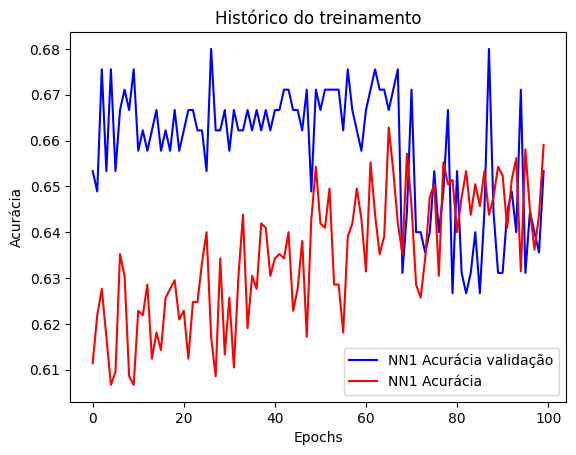

In [21]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino1.history['val_accuracy'], color='b', label="NN1 Acurácia validação")
plt.plot(treino1.history['accuracy'], color='r', label="NN1 Acurácia")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

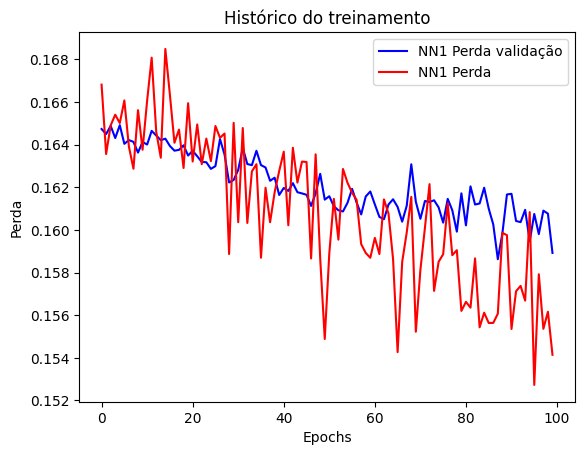

In [22]:
# Plot the loss and accuracy curves for training and validation
plt.plot(treino1.history['val_loss'], color='b', label="NN1 Perda validação")
plt.plot(treino1.history['loss'], color='r', label="NN1 Perda")
plt.title("Histórico do treinamento")
plt.xlabel("Epochs")
plt.ylabel("Perda")
plt.legend()
plt.show()

In [27]:
def viewFilter(model):
    for layer in model.layers:
        if 'conv' not in layer.name:
            continue

        filters, biases = layer.get_weights()
        print(layer.name, filters.shape, filters.shape[3])
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)


        n_filters, ix = filters.shape[3], 1
        for i in range(n_filters):
            f = filters[:, :, :, i]
            ax = plt.subplot(n_filters, 6, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, 0], cmap='gray')
            ix += 1

        plt.show()

conv2d (5, 5, 1, 8) 8


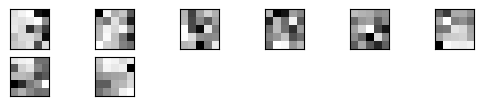

conv2d_1 (2, 2, 8, 8) 8


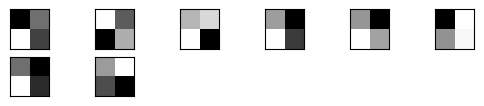

In [28]:
viewFilter(nn1)